In [ ]:
import os
os.environ["OMP_NUM_THREADS"] = "2"
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
print(os.environ.get("OMP_NUM_THREADS"))
print(os.environ.get("KMP_DUPLICATE_LIB_OK"))

In [1]:
#### Imports & settings

# ==========================================
# 1. Data Reading and Processing
# ==========================================


from pathlib import Path # for reading data
import cv2 # read image and resize it
from sklearn.model_selection import train_test_split, cross_val_score,cross_val_predict, StratifiedKFold ,GridSearchCV # Tests ,Kfolds and splitting
from sklearn.cluster import KMeans # for clustering 
#from sklearn.pipeline import Pipeline               # pipeline (split,scale,train)
import numpy as np    # for storing data
np.set_printoptions(precision=2)

# ==========================================
# 2. MODEL , Metrics and Plotting
# ==========================================

import time # for computation analysis
import joblib # for storing the model
from sklearn.neural_network import MLPClassifier ## neural network
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score , make_scorer  # metrics and score
import matplotlib.pyplot as plt  # plotting and visualizing
import pandas as pd   ## utility for storing scores
# display options
pd.set_option('display.float_format', '{:.2f}'.format) 
pd.set_option('display.max_rows', None) 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


# # ==========================================
# # 3. utils
# # ==========================================

# import warnings
# from sklearn.exceptions import ConvergenceWarning

In [48]:
def load_dataset(root_path,files_per_folder=1000):
    """
    Reads DIDA dataset from folders '0' through '9'.
    Returns:
        X: {files_per_folder}*10 images
        files_name {files_per_folder}*10 : files read
    """
    print(f"Loading data from: {root_path}")
    start_time= time.time()
    
    global_index = 0
    X = []
    read_files=[]
    # 2. Iterate through folders 0 to 9
    for digit in range(10):
        folder_path = root_path/str(digit)   # path object use "/" for subdirectory
        # Get list of files
        if not Path.exists(folder_path):
            raise FileNotFoundError(f"Folder {folder_path} not found!")

        # OS file order can be random. just to ensure reproducibility.
        all_files = [p for p in folder_path.iterdir() if p.is_file()]
        rng= np.random.default_rng(42)
        files = sorted(rng.choice(all_files,size=files_per_folder,replace=False))   ## sampling data if you train pick files_per_folder less than 1000
        read_files.append(files)
        # Check: If a folder has the right number of images
        if len(files) != files_per_folder:
            raise ValueError(f"Folder '{digit}' has {len(files)} images, but expected {files_per_folder}. Check your data!")

        # 3. Read images
        for filename in files:

            # Read as Grayscale (ignore color channels if any)
            img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

            if img is None:
                print(f"Warning: Could not read image {img_path}")
                continue

            X.append(np.array(img))
            global_index += 1
    elapsed_time= time.time() - start_time
    read_files= np.sort(np.array(read_files),axis=1)
    print(f"Successfully loaded {global_index} images in {elapsed_time} seconds.")
    read_files= np.sort(np.array(read_files),axis=1)
    y = np.arange(0,10).repeat(files_per_folder)
    return X,y,read_files

In [68]:
def binarize_center_resize(imgs, target_size=(28, 28)):
    all_imgs_edited = np.zeros((len(imgs),28,28))
    
    for i in range(len(imgs)):
        # remove stained pixels
        denoised = cv2.medianBlur(imgs[i], 3)
        
        # separate background and ink
        pixels = denoised.reshape(-1, 1).astype(float)
        kmeans = KMeans(n_clusters=2, n_init=10, max_iter=300)
        labels = kmeans.fit_predict(pixels)
        
        # get the ink cluster
        centers = kmeans.cluster_centers_
        ink_label = np.argmin(centers)
        
        # binary mask reversed ( white for ink black for backgroud)
        binary_img = np.zeros_like(labels, dtype=np.uint8)
        binary_img[labels == ink_label] = 255
        binary_img = binary_img.reshape(denoised.shape)
        
        # 4. Centering ink
        coords = np.column_stack(np.where(binary_img > 0))
        
        if coords.shape[0] > 0:
            # extract Bounding Box
            x, y, w, h = cv2.boundingRect(binary_img)
            digit_crop = binary_img[y:y+h, x:x+w]
            
            # padding to 20
            f = 20.0 / max(w, h)
            
            #new resolution
            new_w = int(w * f)
            new_h = int(h * f)

            #ensure resolution is not zero
            safe_w = max(1, new_w)
            safe_h = max(1, new_h)
            
            digit_resized = cv2.resize(digit_crop, (safe_w, safe_h))
            # ----------------------------------------
            
            # centering image
            res_h, res_w = digit_resized.shape
            final_img = np.zeros(target_size, dtype=np.uint8)
            start_y = (target_size[0] - res_h) // 2
            start_x = (target_size[1] - res_w) // 2
            final_img[start_y:start_y+res_h, start_x:start_x+res_w] = digit_resized
        else:
            # if image is empty
            final_img = cv2.resize(binary_img, target_size)

        all_imgs_edited[i] = final_img
    print(f"All Images_Edited: {all_imgs_edited.shape}")
        
       

    return all_imgs_edited

In [50]:
def normalize_flatten_split(imgs, target):

    normalized_imgs = (imgs.astype(np.float32) / 255.0).reshape((imgs.shape[0],784))

    X_train, X_test, y_train, y_test = train_test_split(
        normalized_imgs, target, test_size=0.20, random_state=42, stratify=target
    )

    print(f"Training Set: {X_train.shape}")
    print(f"Test Set (Held Out): {X_test.shape}")

    return X_train, X_test, y_train, y_test

In [ ]:
# load data
root_path= Path.cwd()/'DIDA'  # Base folder
X ,y, read_files = load_dataset(root_path)

In [ ]:
semi_X = binarize_center_resize(X)

In [74]:
# target creation and splitting
X_train, X_test, y_train, y_test = normalize_flatten_split(semi_X ,y)

Training Set: (8000, 784)
Test Set (Held Out): (2000, 784)


In [75]:
model_config = {
        'model': MLPClassifier(random_state=42,max_iter=2000,verbose=True),
        'params': {
           
            'hidden_layer_sizes': [
                 (350 ,250,150,100,70,25,10) # 7 layers
                ,(1000 ,500, 200,100,50,5)   # 5 layers
                ,(500,100,10)                # 3 layers
                ,(700,200)                   # 2 layers
            ]
        }
    }

# Define the metrics we want to track
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1': 'f1_macro'
}

In [76]:
print("="*60)
print("PHASE 1: Hyperparameter Tuning & Cross-Validation Analysis")
print("="*60)


running_time=0 # compute cell execution time ( just for debugging)

print(f"\nRunning GridSearchCV for NN...")
# 1. Configure GridSearch
grid = GridSearchCV(
    estimator=model_config['model'],
    param_grid=model_config['params'],
    cv=5,                         # 5-Fold Stratified CV
    scoring=scoring_metrics,      # Capture ALL 4 metrics
    refit='accuracy',             
    n_jobs=-1,
    verbose=3

)
# compute time 
start_time=time.time()
# 2. Run Training
grid.fit(X_train, y_train)
end_time=time.time()
elapsed_time=end_time - start_time
print(f'Cell Execution took {running_time} seconds') 
display(grid)

PHASE 1: Hyperparameter Tuning & Cross-Validation Analysis

Running GridSearchCV for NN...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Iteration 1, loss = 1.39183380
Iteration 2, loss = 0.81466108
Iteration 3, loss = 0.59723512
Iteration 4, loss = 0.44479741
Iteration 5, loss = 0.31866648
Iteration 6, loss = 0.21265781
Iteration 7, loss = 0.14290825
Iteration 8, loss = 0.08484331
Iteration 9, loss = 0.05366359
Iteration 10, loss = 0.03490784
Iteration 11, loss = 0.02245385
Iteration 12, loss = 0.01501355
Iteration 13, loss = 0.01051230
Iteration 14, loss = 0.00824079
Iteration 15, loss = 0.00662866
Iteration 16, loss = 0.00554924
Iteration 17, loss = 0.00477245
Iteration 18, loss = 0.00412873
Iteration 19, loss = 0.00361716
Iteration 20, loss = 0.00315666
Iteration 21, loss = 0.00279551
Iteration 22, loss = 0.00248970
Iteration 23, loss = 0.00224637
Iteration 24, loss = 0.00203166
Iteration 25, loss = 0.00184781
Iteration 26, loss = 0.00169160
Iteration 27, loss = 0.001

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",MLPClassifier... verbose=True)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'hidden_layer_sizes': [(350, ...), (1000, ...), ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.","{'accuracy': 'accuracy', 'f1': 'f1_macro'}"
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",'accuracy'
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed

   -> Best Params: {'hidden_layer_sizes': (700, 200)}
   -> Mean Accuracy: 0.8129
   -> Training Time: 78.0328s
   -> Generating Confusion Matrix...
Iteration 1, loss = 1.49646880
Iteration 2, loss = 0.87247897
Iteration 3, loss = 0.64948279
Iteration 4, loss = 0.47187175
Iteration 5, loss = 0.33440560
Iteration 6, loss = 0.23323862
Iteration 7, loss = 0.15814161
Iteration 8, loss = 0.10058727
Iteration 9, loss = 0.06444635
Iteration 10, loss = 0.03962217
Iteration 11, loss = 0.02548456
Iteration 12, loss = 0.01720371
Iteration 13, loss = 0.01320226
Iteration 14, loss = 0.01012421
Iteration 15, loss = 0.00840153
Iteration 16, loss = 0.00688076
Iteration 17, loss = 0.00582709
Iteration 18, loss = 0.00504617
Iteration 19, loss = 0.00438403
Iteration 20, loss = 0.00385206
Iteration 21, loss = 0.00348477
Iteration 22, loss = 0.00309195
Iteration 23, loss = 0.00280977
Iteration 24, loss = 0.00255283
Iteration 25, loss = 0.00233674
Iteration 26, loss = 0.00215446
Iteration 27, loss = 0.00199

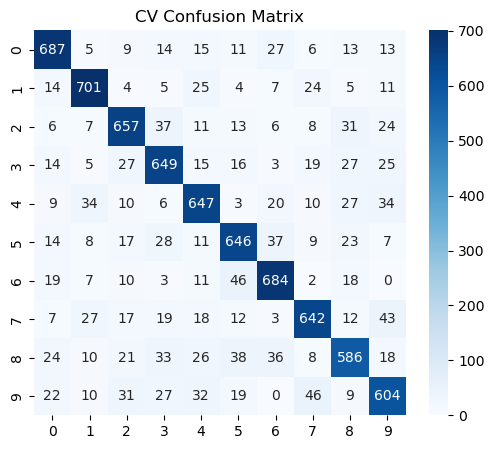

In [80]:
# 3. Capture Best Results
best_model = grid.best_estimator_
results = grid.cv_results_
best_index = grid.best_index_ # Index of the winning combo
# 4. Extract Metrics for the *Winner* only
# GridSearch returns metrics for ALL combinations. We only want the best one.
best_summary = {
    'Best Params': grid.best_params_,
    'Mean Accuracy': results['mean_test_accuracy'][best_index],
    'Mean F1': results['mean_test_f1'][best_index],
    'Training Time (s)': results['mean_fit_time'][best_index]
}
all_summary = {
    'Params': results['params'],
    'Mean Accuracy': results['mean_test_accuracy'],
    'Mean F1': results['mean_test_f1'],
    'Training Time (s)': results['mean_fit_time'],
    'Rank': results["rank_test_f1"]
    
}

print(f"   -> Best Params: {grid.best_params_}")
print(f"   -> Mean Accuracy: {best_summary['Mean Accuracy']:.4f}")
print(f"   -> Training Time: {best_summary['Training Time (s)']:.4f}s")
# 5. Generate Confusion Matrix (Separately via cross_val_predict)
print("   -> Generating Confusion Matrix...")
y_pred_cv = cross_val_predict(grid.best_estimator_, X_train, y_train, cv=5)
cm = confusion_matrix(y_train, y_pred_cv)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'CV Confusion Matrix')
plt.show()

In [12]:
stats=pd.DataFrame(all_summary)
stats["Layers"]=[len(i['hidden_layer_sizes']) for i in stats["Params"]]
stats['Params']= stats["Params"].astype(str).str.split(r'[()]').str[1]
stats.rename({"Params":"Structure"},axis=1,inplace=True)
stats["Structure"] =  "(" + stats["Structure"]  + ")"
stats=stats.iloc[:,[5,0,1,2,3,4]]
stats.sort_values(by="Rank",ignore_index=True,ascending=True,inplace=True)
stats

,Layers,Structure,Mean Accuracy,Mean F1,Training Time (s),Rank
0,2,"(700, 200)",0.81,0.81,78.03,1
1,3,"(500, 100, 10)",0.78,0.78,85.97,2
2,6,"(1000, 500, 200, 100, 50, 5)",0.77,0.77,183.14,3
3,7,"(350, 250, 150, 100, 70, 25, 10)",0.75,0.75,78.68,4


In [83]:
print("="*60)
print("PHASE 2: Final Test Set Evaluation (The Vault)")
print("="*60)
cls_report=[]
final_metrics = []
target_names=[f"Digit {i}" for i in range(0,10)]

print(f"\nEvaluating Best Model on Test Set...")
# 1. Predict (Model is already refitted on X_train by GridSearchCV)
y_pred = best_model.predict(X_test)
# 2. Calculate Final Metrics
acc = accuracy_score(y_test, y_pred)
print(f"   -> Final Test Accuracy: {acc:.4f}")
# Store for final report
final_metrics.append({
    'Test Accuracy': acc
})

metrics_df=pd.DataFrame(final_metrics)
display(metrics_df)

PHASE 2: Final Test Set Evaluation (The Vault)

Evaluating Best Model on Test Set...
   -> Final Test Accuracy: 0.8165


,Test Accuracy
0,0.82


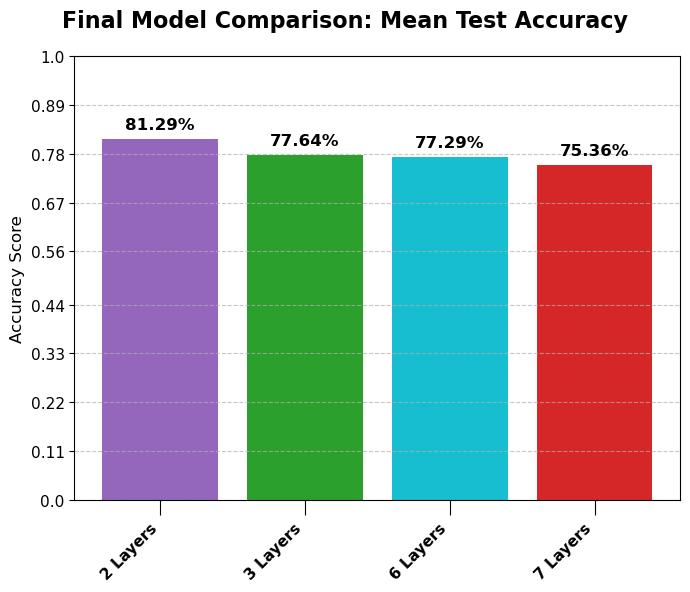

In [130]:
data_bar = pd.DataFrame({
    "Layers_Structure": stats["Layers"].astype(str) + " Layers",
    "Mean Accuracy": stats["Mean Accuracy"]
})

fig , ax = plt.subplots()
fig.set_size_inches((7,6))
# 2. Create the Chart
#bars =ax.bar([0,1,5,12],data_bar["Mean Accuracy"],color=['tab:purple', 'tab:green', 'tab:cyan', 'tab:red'])
bars =ax.bar(data_bar["Layers_Structure"],data_bar["Mean Accuracy"],color=['tab:purple', 'tab:green', 'tab:cyan', 'tab:red'])
# 3. Add Styling and Labels
fig.suptitle('Final Model Comparison: Mean Test Accuracy', fontsize=16, fontweight='bold')
ax.set_ylabel('Accuracy Score', fontsize=12)
ax.set_xticks(range(len(data_bar)))  # positions: 0,1,2,3,...
ax.set_xticklabels(data_bar["Layers_Structure"], ha="right", rotation=45, fontsize=11,fontweight="bold")
ax.tick_params('x',rotation=45,size=11)
ax.set_yticks([0.  , 0.11, 0.22, 0.33, 0.44, 0.56, 0.67, 0.78, 0.89, 1.  ],[0.  , 0.11, 0.22, 0.33, 0.44, 0.56, 0.67, 0.78, 0.89, 1.  ],fontsize=11) #
ax.grid(axis='y', linestyle='--', alpha=0.7)

ax.le
for p in ax.patches:
    # Calculate the text position
    height = p.get_height()
    ax.annotate(f'{height:.2%}',  # Format as percentage
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom',
                fontsize=12, fontweight='bold', color='black',
                xytext=(0, 5),
                textcoords='offset points')

# 5. Show the plot
plt.tight_layout()
plt.show()